# HW2

# II. Analyzing Data

In [70]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import importlib
import utils as ut
importlib.reload(ut)

<module 'utils' from '/Users/chuan/github/0_Quantitative_Portfolio_Manager/homework/utils.py'>

In [2]:
file_path = './../data/proshares_analysis_data.xlsx'

descriptions = pd.read_excel(file_path) # first sheet
descriptions.set_index(descriptions.columns[0], inplace=True)
descriptions.index.name = 'Symbol'
display(descriptions)

hedge_funds = pd.read_excel(file_path, sheet_name='hedge_fund_series')
hedge_funds.set_index(hedge_funds.columns[0], inplace=True)
hedge_funds.index.name = 'Date'
display(hedge_funds)

merrill_factors = pd.read_excel(file_path, sheet_name='merrill_factors')
merrill_factors.set_index(merrill_factors.columns[0], inplace=True)
merrill_factors.index.name = 'Date'
# display(merrill_factors)

other_data = pd.read_excel(file_path, sheet_name='other_data')
other_data.set_index(other_data.columns[0], inplace=True)
other_data.index.name = 'Date'
# display(other_data)

,security_name
Symbol,
EEM US Equity,iShares MSCI Emerging Markets
EFA US Equity,iShares MSCI EAFE ETF
EUO US Equity,ProShares UltraShort Euro
HDG US Equity,ProShares Hedge Replication ET
HEFA US Equity,iShares Currency Hedged MSCI E
HFRIFWI Index,HFR Fund Wghted Comp
IWM US Equity,iShares Russell 2000 ETF
MLEIFCTR Index,Merrill Lynch Factor Model Ind
MLEIFCTX Index,Merrill Lynch Factor Model Exc


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.0321,-0.0256,-0.0257,-0.0270,-0.0065
2011-09-30,-0.0389,-0.0324,-0.0326,-0.0325,-0.0221
2011-10-31,0.0269,0.0436,0.0433,0.0505,0.0252
2011-11-30,-0.0135,-0.0121,-0.0124,-0.0286,-0.0080
2011-12-31,-0.0045,0.0019,0.0018,0.0129,0.0018
...,...,...,...,...,...
2023-04-30,0.0024,0.0009,0.0003,-0.0004,0.0051
2023-05-31,-0.0020,-0.0010,-0.0015,-0.0014,-0.0065
2023-06-30,0.0214,0.0159,0.0159,0.0167,0.0226


## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [3]:
ut.performance_metrics_annualized(hedge_funds)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
HFRIFWI Index,0.0432,0.0602,0.7177,-0.0908,0.0586,-0.1155
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.0532,0.0589,-0.1243
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.0524,0.0588,-0.1244
HDG US Equity,0.0205,0.0594,0.3455,-0.0592,0.0583,-0.1407
QAI US Equity,0.0196,0.0501,0.3917,-0.0563,0.0398,-0.1377


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [4]:
def maximum_drawdown(returns):
    """Calculate the maximum drawdown for each asset for returns,
    and max/min/recovery dates within the max drawdown period."""

    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdowns.min() # series
    end_date = drawdowns.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdowns.columns:
        peak_date = rolling_max.loc[:end_date[col], col].idxmax()
        try:
            recovery = drawdowns.loc[end_date[col]:, col] # after the bottom
            recovery_date = recovery[recovery >= 0].index[0]
        except IndexError:
            recovery_date = None
        duration = recovery_date - peak_date if recovery_date else None

        summary.loc[col, 'Peak'] = peak_date
        summary.loc[col, 'Recovery'] = recovery_date
        summary.loc[col, 'Duration'] = duration

    return summary

maximum_drawdown(hedge_funds)

,Max Drawdown,Bottom,Peak,Recovery,Duration
HFRIFWI Index,-0.1155,2020-03-31,2019-12-31,2020-08-31,244 days
MLEIFCTR Index,-0.1243,2022-09-30,2021-06-30,NaT,NaT
MLEIFCTX Index,-0.1244,2022-09-30,2021-06-30,NaT,NaT
HDG US Equity,-0.1407,2022-09-30,2021-06-30,NaT,NaT
QAI US Equity,-0.1377,2022-09-30,2021-06-30,NaT,NaT


In [5]:
ut.tail_metrics(hedge_funds)

,Skewness,Kurtosis,VaR 5%,CVaR 5%,Max Drawdown,Bottom,Peak,Recovery,Duration
HFRIFWI Index,-0.9832,5.9183,-0.0251,-0.0375,-0.1155,2020-03-31,2019-12-31,2020-08-31,244 days
MLEIFCTR Index,-0.2558,1.6643,-0.0287,-0.0359,-0.1243,2022-09-30,2021-06-30,NaT,NaT
MLEIFCTX Index,-0.2418,1.6316,-0.0289,-0.0358,-0.1244,2022-09-30,2021-06-30,NaT,NaT
HDG US Equity,-0.2440,1.7801,-0.0312,-0.0376,-0.1407,2022-09-30,2021-06-30,NaT,NaT
QAI US Equity,-0.4584,1.7376,-0.0201,-0.0327,-0.1377,2022-09-30,2021-06-30,NaT,NaT


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [6]:
ut.performance_metrics_annualized(merrill_factors)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
SPY US Equity,0.1332,0.1459,0.9129,-0.1249,0.1270,-0.2393
USGG3M Index,0.0094,0.0040,2.3339,-0.0000,0.0045,-0.0000
EEM US Equity,0.0228,0.1862,0.1223,-0.1791,0.1630,-0.3655
EFA US Equity,0.0579,0.1558,0.3718,-0.1411,0.1427,-0.2762
EUO US Equity,0.0583,0.1568,0.3718,-0.0977,0.1442,-0.2681
IWM US Equity,0.1044,0.1942,0.5378,-0.2148,0.1824,-0.3229


In [7]:
def regression_statistics_annualized(returns, benchmark, annual_factor=12):
    """Calculate regression statistics for each asset against a benchmark, annualized."""

    results = pd.DataFrame(index=returns.columns)
    for col in returns.columns:
        regr = sm.OLS(returns[col], sm.add_constant(benchmark)).fit()
        results.loc[col, 'Alpha'] = regr.params[0] * annual_factor
        results.loc[col, 'Beta'] = regr.params[1]
        results.loc[col, 'R^2'] = regr.rsquared
        results.loc[col, 'Treynor Ratio'] = returns[col].mean() / regr.params[1] * annual_factor
        results.loc[col, 'Information Ratio'] = regr.params[0] / regr.resid.std() * np.sqrt(annual_factor)

    return results

spy = merrill_factors['SPY US Equity']
regression_statistics_annualized(hedge_funds, spy)

,Alpha,Beta,R^2,Treynor Ratio,Information Ratio
HFRIFWI Index,-0.0032,0.3487,0.7140,0.1240,-0.1005
MLEIFCTR Index,-0.0147,0.3496,0.8023,0.0912,-0.5803
MLEIFCTX Index,-0.0160,0.3483,0.8008,0.0873,-0.6316
HDG US Equity,-0.0274,0.3594,0.7805,0.0571,-0.9839
QAI US Equity,-0.0198,0.2961,0.7449,0.0662,-0.7844


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

SPY vs. Hedge Funds:
- SPY has significantly outperformed hedge funds due to its strong bull market performance during this time, as shown by SPY's high Sharpe Ratio (0.9). Hedge funds have underperfomed and all have negative Information Ratio (which is the Sharpe Ratio of the hedged position).

HDG vs. QAI:
- QAI performs better than HDG, with higher Treynor Ratio and less negative Information Ratio.

HFRI vs. ML and HDG:
- HFRI stands out as the broad index with better hedged performance (less negative alpha and Information Ratio) and a higher Treynor Ratio. 
- ML and HDG capture some of its market-related behavior (beta and R²) but fail to replicate its active management success.

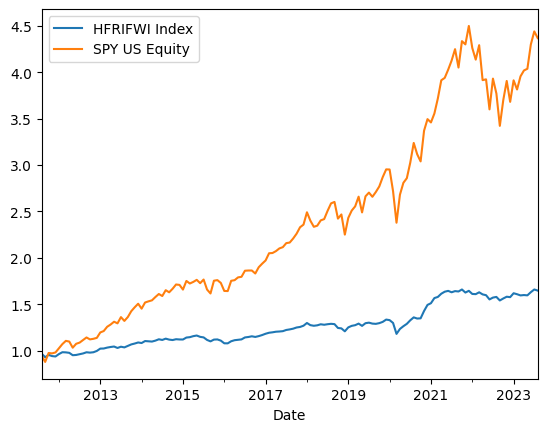

In [8]:
hfri = hedge_funds['HFRIFWI Index']
cumrets = (1 + pd.concat([hfri, spy], axis=1)).cumprod()
cumrets.plot();

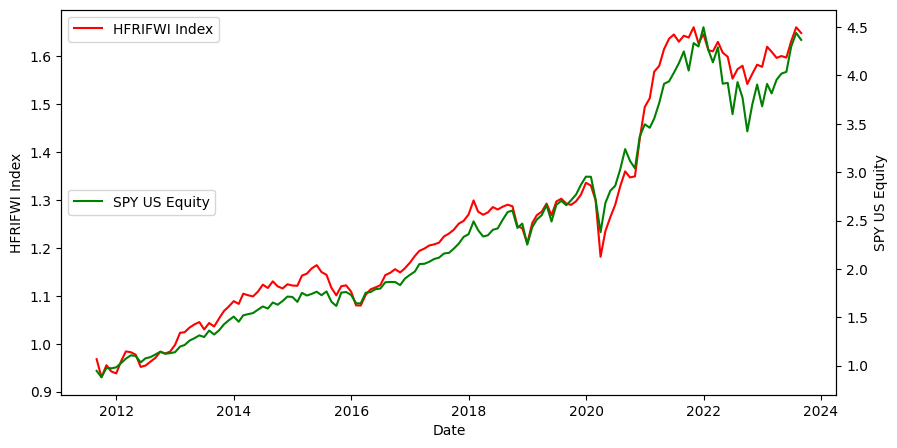

In [9]:
# Allowing the vertical scales to be different for the two series
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel(hfri.name)
ax1.plot(hfri.index, (1+hfri).cumprod(), color='r', label=hfri.name)

ax2 = ax1.twinx()  
ax2.set_ylabel(spy.name)  
ax2.plot(spy.index, (1+spy).cumprod(), color='g', label=spy.name)

ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.show()

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

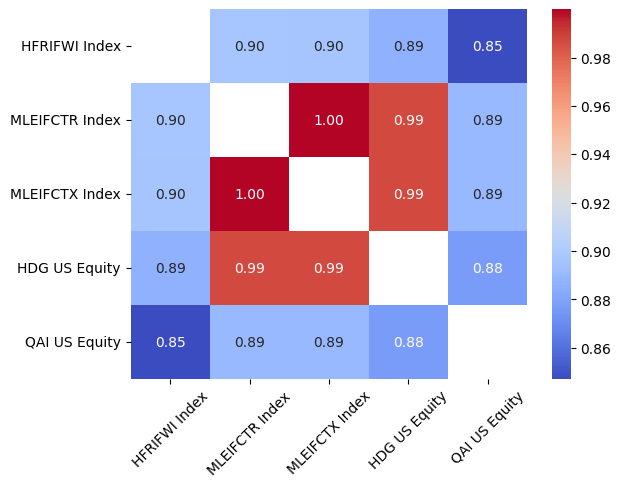

Max corr 1.00: ('MLEIFCTX Index', 'MLEIFCTR Index')
Min corr 0.85: ('HFRIFWI Index', 'QAI US Equity')


In [10]:
def correlation_heatmap(returns):
    """Plot a heatmap of the correlation matrix of the returns, off-diagonal only.
    Print MIN, MAX of correlations."""
    corr_matrix = returns.corr()
    mask = np.eye(corr_matrix.shape[0], dtype=bool) # Highlight diagonal
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, fmt='.2f')
    plt.xticks(rotation=45)
    plt.show()

    corrs = corr_matrix.unstack().sort_values(ascending=False)
    corrs = corrs[corrs != 1] # Remove self-correlations

    print(f"Max corr {max(corrs):.2f}: {corrs.idxmax()}")
    print(f"Min corr {min(corrs):.2f}: {corrs.idxmin()}")

correlation_heatmap(hedge_funds)

## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

#### a. Report the intercept and betas.
#### b. Are the betas realistic position sizes, or do they require huge long-short positions?
#### c. Report the R-squared.
#### d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [11]:
regr = sm.OLS(hfri, sm.add_constant(merrill_factors)).fit()
print(f"The volatility of the tracking error: {regr.resid.std():.3f}")
display(regr.summary())

The volatility of the tracking error: 0.007


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     118.0
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           7.98e-52
Time:                        10:47:49   Log-Likelihood:                 513.78
No. Observations:                 145   AIC:                            -1014.
Df Residuals:                     138   BIC:                            -992.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.815      0.072      -0.000       0.003
SPY US Equity     0.0333      0.038      0.885      0.378      -0.041       0.108
USGG3M Index     -0.1659      0.518     -0.320      0.749      -1.190       0.858
EEM US Equity     0.0779      0.022      3.605      0.000       0.035       0.121
EFA US Equity     0.0824      0.036      2.271      0.025       0.011       0.154
EUO US Equity     0.0226      0.018      1.282      0.202      -0.012       0.058
IWM US Equity     0.1521      0.023      6.567      0.000       0.106       0.198
==============================================================================
Omnibus:                       22.456   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.552
Skew:                          -0.481   Prob(JB):                     1.76e-16
Kurtosis:                       6.329   Cond. No.                         869.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [18]:
%%time
def rolling_regression(returns, factors, window=60):
    """Calculate rolling regression statistics for each asset against factors,
    and evaluate replication performance."""
    results = pd.DataFrame(index=returns.index[window:])

    for i in range(window, len(returns)):
        start_date = returns.index[i] - pd.DateOffset(months=window)
        end_date = returns.index[i]

        returns_is = returns[(returns.index >= start_date) & (returns.index < end_date)]
        factors_is = factors[(factors.index >= start_date) & (factors.index < end_date)]
        factors_oos = factors[factors.index == end_date]

        regr = sm.OLS(returns_is, sm.add_constant(factors_is)).fit()

        predicted = regr.predict(sm.add_constant(factors_oos, has_constant='add'))
        actual = returns[returns.index == end_date]

        results.loc[end_date, 'Predicted'] = predicted.iloc[0]
        results.loc[end_date, 'Actual'] = actual.iloc[0]
        results.loc[end_date, 'Residual'] = actual.iloc[0] - predicted.iloc[0] # standard regression analysis
    
    return results


rolling_results = rolling_regression(hfri, merrill_factors)
rolling_results

CPU times: user 734 ms, sys: 25.1 ms, total: 759 ms
Wall time: 1.69 s


,Predicted,Actual,Residual
Date,,,
2016-08-31,0.0050,0.0043,-0.0007
2016-09-30,0.0050,0.0065,0.0015
2016-10-31,-0.0044,-0.0059,-0.0015
2016-11-30,0.0117,0.0077,-0.0040
2016-12-31,0.0076,0.0101,0.0024
...,...,...,...
2023-04-30,-0.0060,0.0024,0.0084
2023-05-31,-0.0082,-0.0020,0.0062
2023-06-30,0.0227,0.0214,-0.0013


In [68]:
%%time
from statsmodels.regression.rolling import RollingOLS

def rolling_regression(returns, factors, window=60):
    """Calculate rolling regression statistics for each asset against factors, vectorized,
    and compare replication performance of static, is, oos against actual returns."""
    regr = RollingOLS(returns, sm.add_constant(factors), window=window)
    rolling_betas = regr.fit().params
    
    replication_is = (rolling_betas * sm.add_constant(factors)).sum(axis=1, skipna=False) # in-sample replication
    replication_oos = (rolling_betas.shift() * sm.add_constant(factors)).sum(axis=1, skipna=False) # out-of-sample replication

    static_regr = sm.OLS(returns, sm.add_constant(factors)).fit() # static regression as benchmark
    replication_static = static_regr.fittedvalues

    return pd.DataFrame({'Actual': returns, 'Static IS': replication_static, 'Rolling IS': replication_is, 'Rolling OOS': replication_oos})

CPU times: user 24 μs, sys: 77 μs, total: 101 μs
Wall time: 113 μs


In [69]:
replication = ut.rolling_regression(hfri, merrill_factors, window=60, intercept=True)
replication

,Actual,Static IS YesInt,Rolling IS YesInt,Rolling OOS YesInt
Date,,,,
2011-08-31,-0.0321,-0.0285,0.0000,0.0000
2011-09-30,-0.0389,-0.0375,0.0000,0.0000
2011-10-31,0.0269,0.0470,0.0000,0.0000
2011-11-30,-0.0135,-0.0014,0.0000,0.0000
2011-12-31,-0.0045,-0.0009,0.0000,0.0000
...,...,...,...,...
2023-04-30,0.0024,-0.0004,-0.0049,-0.0060
2023-05-31,-0.0020,-0.0040,-0.0065,-0.0082
2023-06-30,0.0214,0.0214,0.0227,0.0227


In [59]:
replication.corr()

,Actual,Static IS YesInt,Rolling IS YesInt,Rolling OOS YesInt
Actual,1.0000,0.9148,0.8029,0.7650
Static IS YesInt,0.9148,1.0000,0.7949,0.7879
Rolling IS YesInt,0.8029,0.7949,1.0000,0.9881
Rolling OOS YesInt,0.7650,0.7879,0.9881,1.0000


## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [48]:
regr = sm.OLS(hfri, sm.add_constant(merrill_factors)).fit()
regr_no_const = sm.OLS(hfri, merrill_factors).fit()

betas = pd.DataFrame({'Yes Intercept': regr.params, 'No Intercept': regr_no_const.params}).T
betas

,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,SPY US Equity,USGG3M Index,const
Yes Intercept,0.0779,0.0824,0.0226,0.1521,0.0333,-0.1659,0.0014
No Intercept,0.0776,0.0753,0.0256,0.1486,0.0509,0.3378,NaN


Without an intercept, the betas are almost identical, except the beta in the 3-month `USGG3M Index`. Below assembles more replication statistics.

In [81]:
replication_yes_int = ut.rolling_regression(hfri, merrill_factors, window=60, intercept=True)
replication_no_int = ut.rolling_regression(hfri, merrill_factors, window=60, intercept=False)
replication = pd.merge(replication_yes_int, replication_no_int, left_index=True, right_index=True).drop(columns=['Actual_y'])
replication

,Actual_x,Static IS YesInt,Rolling IS YesInt,Rolling OOS YesInt,Static IS NoInt,Rolling IS NoInt,Rolling OOS NoInt
Date,,,,,,,
2011-08-31,-0.0321,-0.0285,NaN,NaN,-0.0299,NaN,NaN
2011-09-30,-0.0389,-0.0375,NaN,NaN,-0.0385,NaN,NaN
2011-10-31,0.0269,0.0470,NaN,NaN,0.0461,NaN,NaN
2011-11-30,-0.0135,-0.0014,NaN,NaN,-0.0025,NaN,NaN
2011-12-31,-0.0045,-0.0009,NaN,NaN,-0.0017,NaN,NaN
...,...,...,...,...,...,...,...
2023-04-30,0.0024,-0.0004,-0.0049,-0.0060,0.0004,-0.0025,-0.0031
2023-05-31,-0.0020,-0.0040,-0.0065,-0.0082,-0.0026,-0.0018,-0.0023
2023-06-30,0.0214,0.0214,0.0227,0.0227,0.0226,0.0255,0.0261


In [82]:
ut.performance_metrics_annualized(replication)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Actual_x,0.0432,0.0602,0.7177,-0.0908,0.0586,-0.1155
Static IS YesInt,0.0432,0.0551,0.7845,-0.0593,0.0505,-0.0912
Rolling IS YesInt,0.0406,0.0609,0.6657,-0.0664,0.0554,-0.0965
Rolling OOS YesInt,0.0386,0.0603,0.6402,-0.0537,0.0537,-0.0975
Static IS NoInt,0.0331,0.0556,0.5955,-0.0611,0.0493,-0.0944
Rolling IS NoInt,0.0420,0.0618,0.6803,-0.0660,0.0549,-0.1043
Rolling OOS NoInt,0.0417,0.0616,0.6767,-0.0543,0.0534,-0.1116


In [83]:
ut.summary_statistics_annualized(replication)

,Mean,Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR 5%,CVaR 5%,Max Drawdown,Bottom,Peak,Recovery,Duration
Actual_x,0.0432,0.0602,0.7177,-0.0908,0.0586,-0.9832,5.9183,-0.0251,-0.0375,-0.1155,2020-03-31,2019-12-31,2020-08-31,244 days
Static IS YesInt,0.0432,0.0551,0.7845,-0.0593,0.0505,-0.4646,1.7822,-0.0247,-0.0331,-0.0912,2020-03-31,2019-12-31,2020-08-31,244 days
Rolling IS YesInt,0.0406,0.0609,0.6657,-0.0664,0.0554,-0.6869,2.6400,-0.0269,-0.0374,-0.0965,2020-03-31,2019-12-31,2020-08-31,244 days
Rolling OOS YesInt,0.0386,0.0603,0.6402,-0.0537,0.0537,-0.4615,1.2470,-0.0272,-0.0361,-0.0975,2022-09-30,2021-12-31,NaT,NaT
Static IS NoInt,0.0331,0.0556,0.5955,-0.0611,0.0493,-0.4633,1.7955,-0.0261,-0.0343,-0.0944,2020-03-31,2019-12-31,2020-11-30,335 days
Rolling IS NoInt,0.0420,0.0618,0.6803,-0.0660,0.0549,-0.6551,2.4149,-0.0277,-0.0380,-0.1043,2022-09-30,2021-06-30,NaT,NaT
Rolling OOS NoInt,0.0417,0.0616,0.6767,-0.0543,0.0534,-0.4267,1.1901,-0.0273,-0.0370,-0.1116,2022-09-30,2021-06-30,NaT,NaT


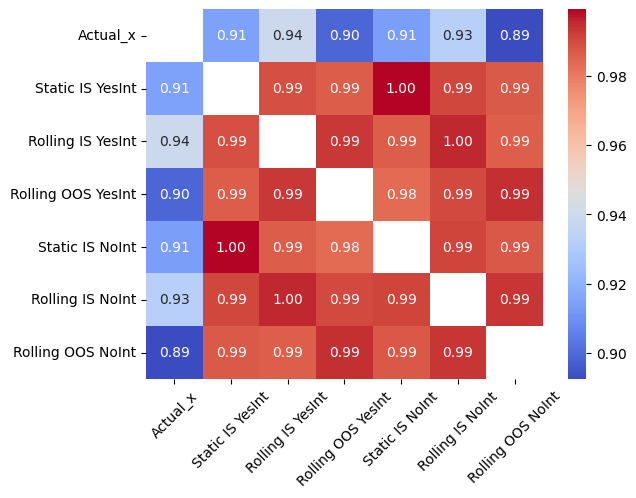

Max corr 1.00: ('Static IS YesInt', 'Static IS NoInt')
Min corr 0.89: ('Actual_x', 'Rolling OOS NoInt')


In [84]:
ut.correlation_heatmap(replication)

These replications are almost the same. 
* Their correlations are very high to the with-intercept versions.
* The means and other performance statistics are quite similar.

***

# 3.  Extensions
<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?



## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?